# Introduction

We have learned a lot about CNNs. And in this notebook we will talk about a detail that is been happening behind the scenes when we build and train neural networks in PyTorch, and that's weights initialization.

Weight initialization happens right when a model is created, before it sees any training data, and it generally only happens one time when a model is first created. Weight initialization is all about how we can instantiate a model, like a CNN, so that its weights, the model parameters, are starting off with the best initial values for a given task. 

We recommend to thing of it this way, any neuron in a model has some weights and biases that operate on some input values and transform them into desired outputs. It is how we might transform an input image into some class scores. A model is trying to learn the best weights to map inputs to outputs and, say, most accurately classify some given images. 

When we did transfer learning, we basically initialized a network with the best pre-trained weights, weights that we know are good values for image classification. But for a non-pretrained model, how should we initialize the weights? We could start for example by saying all the weights are going to be zero, and we will train them until they are shifted up or down, or we could start out with large weight values, or even some random values, and see what happens.

These are the questions that we will be exploring in this notebook.We will demostrate the effect of different weight initialization strategiess, discuss how we might decide on initial weights and what indicates good initial behavior during training. 

The plan: we want to define one kind of model, a simple MLP,  and we will initialize the weights of this model with different values, and compare how the training losses decrease over the first epoch or two of training. Same models, different initial weights. 

Some initialization strategies may offer some really big improvements to how the loss decreases, and others may offer small improvements. Big or small, we can learn from all of these differences. We will be using the Fashion-MNIST dataset. A simple ataset like this one is often used to test network performance, because the dataset is simple to use and its training behavior is fairly well understood. We know for example that we should be able to get the training loss to reliably decrease. 

We will be using a `helpers.py` file, the purpose of this notebook is not to train the model until it performs well on the classification task, but rather we just want to see how well the models train given different initial weights. In that `helpers.py` file we have a main helper function `get_loss_acc`, which takes in a model, and the training and validation model. We defined the length fo time to train a model choosing 2 epochs, and we also defined a loss and optimization functions there, using cross-entropy  and an Adam optimizer, but feel free to change this to Stochastic gradient descent and see how it performs. Then in the function, we are actually going to train the model for 2 epochs, and record the training loss as we go. This loss is going to be recorded in a list called `loss_batch`. After a model has trained for 2 epochs, we then see how it performs on our validation data set. We compare the predicted and the correct class, and see which ones match. Finally, we return the list of training loss over time and that validation accuracy. Another helper function will compare its weights, which takes in a list of models. For each model in our list, it will record the training loss and the validation accuracy over 2 epochs, and compare at least two models. 

# Weight Initialization
In this lesson, you'll learn how to find good initial weights for a neural network. Weight initialization happens once, when a model is created and before it trains. Having good initial weights can place the neural network close to the optimal solution. This allows the neural network to come to the best solution quicker. 

<img src="assets/neuron_weights.png" width=40%/>


## Initial Weights and Observing Training Loss

To see how different weights perform, we'll test on the same dataset and neural network. That way, we know that any changes in model behavior are due to the weights and not any changing data or model structure. 
> We'll instantiate at least two of the same models, with _different_ initial weights and see how the training loss decreases over time, such as in the example below. 

<img src="assets/loss_comparison_ex.png" width=60%/>

Sometimes the differences in training loss, over time, will be large and other times, certain weights offer only small improvements.

### Dataset and Model

We'll train an MLP to classify images from the [Fashion-MNIST database](https://github.com/zalandoresearch/fashion-mnist) to demonstrate the effect of different initial weights. As a reminder, the FashionMNIST dataset contains images of clothing types; `classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']`. The images are normalized so that their pixel values are in a range [0.0 - 1.0).  Run the cell below to download and load the dataset.

---
#### EXERCISE

[Link to normalized distribution, exercise code](#normalex)

---

### Import Libraries and Load [Data](http://pytorch.org/docs/stable/torchvision/datasets.html)

In [2]:
import torch
import numpy as np
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 100
# percentage of training set to use as validation
valid_size = 0.2

# convert data to torch.FloatTensor
transform = transforms.ToTensor()

# choose the training and test datasets
train_data = datasets.FashionMNIST(root='data', train=True,
                                   download=True, transform=transform)
test_data = datasets.FashionMNIST(root='data', train=False,
                                  download=True, transform=transform)

# obtain training indices that will be used for validation
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
    sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
    num_workers=num_workers)

# specify the image classes
classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
    'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

### Visualize Some Training Data

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
    
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title(classes[labels[idx]])

# Constant weights

So, we have the general layout of our MLP, and we are training this model to classify 10 types of clothes in the fashion MNIST dataset. We really just want to look at how a model trains when it is given different initial weights. 

## Define the Model Architecture

We've defined the MLP that we'll use for classifying the dataset.

### Neural Network
<img style="float: left" src="assets/neural_net.png" width=50%/>


* A 3 layer MLP with hidden dimensions of 256 and 128. 

* This MLP accepts a flattened image (784-value long vector) as input and produces 10 class scores as output.
---
We'll test the effect of different initial weights on this 3 layer neural network with ReLU activations and an Adam optimizer.  

The lessons you learn apply to other neural networks, including different activations and optimizers.

---
## Initialize Weights
Let's start looking at some initial weights.
### All Zeros or Ones
If you follow the principle of [Occam's razor](https://en.wikipedia.org/wiki/Occam's_razor), you might think setting all the weights to 0 or 1 would be the best solution.  This is not the case.

With every weight the same, all the neurons at each layer are producing the same output.  This makes it hard to decide which weights to adjust.

Let's compare the loss with all ones and all zero weights by defining two models with those constant weights.

Below, we are using PyTorch's [nn.init](https://pytorch.org/docs/stable/nn.html#torch-nn-init) to initialize each Linear layer with a constant weight. The init library provides a number of weight initialization functions that give you the ability to initialize the weights of each layer according to layer type.

In the case below, we look at every layer/module in our model. If it is a Linear layer (as all three layers are for this MLP), then we initialize those layer weights to be a `constant_weight` with bias=0 using the following code:
>```
if isinstance(m, nn.Linear):
    nn.init.constant_(m.weight, constant_weight)
    nn.init.constant_(m.bias, 0)
```

The `constant_weight` is a value that you can pass in when you instantiate the model.


In [6]:
import torch.nn as nn
import torch.nn.functional as F

# define the NN architecture
class Net(nn.Module):
    def __init__(self, hidden_1=256, hidden_2=128, constant_weight=None):
        super(Net, self).__init__()
        # linear layer (784 -> hidden_1)
        self.fc1 = nn.Linear(28 * 28, hidden_1)
        # linear layer (hidden_1 -> hidden_2)
        self.fc2 = nn.Linear(hidden_1, hidden_2)
        # linear layer (hidden_2 -> 10)
        self.fc3 = nn.Linear(hidden_2, 10)
        # dropout layer (p=0.2)
        self.dropout = nn.Dropout(0.2)
        
        # initialize the weights to a specified, constant value
        if(constant_weight is not None):
            for m in self.modules():
                if isinstance(m, nn.Linear):
                    nn.init.constant_(m.weight, constant_weight)
                    nn.init.constant_(m.bias, 0)
    
            
    def forward(self, x):
        # flatten image input
        x = x.view(-1, 28 * 28)
        # add hidden layer, with relu activation function
        x = F.relu(self.fc1(x))
        # add dropout layer
        x = self.dropout(x)
        # add hidden layer, with relu activation function
        x = F.relu(self.fc2(x))
        # add dropout layer
        x = self.dropout(x)
        # add output layer
        x = self.fc3(x)
        return x


In the if bloc, let's say we have passed in a constant way of zero, then we enter this if statement, the for statement looks at every module or layer in our model. Then it says, let's check the layer type. For every linear layer, we are going to set the parameter weights to a constant value using `nn.init.constant`.  This takes in the weights we want to set from our module and a constant weight value, which we passed in. We do the exact same thing for our module bias, only we are setting the bias to zero. 

So, all we have to do to set the weights is to specify how we want to initialize each linear layer and then use the `nn.init`library to help set those values. This library includes a lot of common initialization schemes that we will go over. 

Next, we actually need to instantiate two different kinds of models with two different constant weights. So, let's create a model with a constant weight `0` and another one with constant weight `1`

### Compare Model Behavior

Below, we are using `helpers.compare_init_weights` to compare the training and validation loss for the two models we defined above, `model_0` and `model_1`.  This function takes in a list of models (each with different initial weights), the name of the plot to produce, and the training and validation dataset loaders. For each given model, it will plot the training loss for the first 100 batches and print out the validation accuracy after 2 training epochs. *Note: if you've used a small batch_size, you may want to increase the number of epochs here to better compare how models behave after seeing a few hundred images.* 

We plot the loss over the first 100 batches to better judge which model weights performed better at the start of training. **I recommend that you take a look at the code in `helpers.py` to look at the details behind how the models are trained, validated, and compared.**

Run the cell below to see the difference between weights of all zeros against all ones.

In [ ]:
# initialize two NN's with 0 and 1 constant weights
model_0 = Net(constant_weight=0)
model_1 = Net(constant_weight=1)

We create the moduls then using the `helpers.py`functions, we are actually going to compare these two models and how they perform over two epics. 

In [ ]:
import helpers

# put them in list form to compare
model_list = [(model_0, 'All Zeros'),
              (model_1, 'All Ones')]


# plot the loss over the first 100 batches
helpers.compare_init_weights(model_list, 
                             'All Zeros vs All Ones', 
                             train_loader,
                             valid_loader)

As we can see, the model that starts out with all ones as weights start out with an extremely hig initial loss. Usually for something with cross entropy loss, we are expecting a value in the single digits. We also see that when a model is initialized with all zeros, its line just sort of remains flat over time and doesn't change. The loss never really decreases. So what exactly is happening here?

Let's talk about our model that starts out with a constant weight of zero. In this case, every single hodden node is going to respond to the inputs it sees in the exact same way. It will multiply all of these inputs by a constant weight of zero and then add all of them up. This behavior repeats in the second layer where all the weights are zero and again in the third producing a series of class scores. Now, in any training process, these class scores will not be very accurate at first, but that's okay as long as we can learn from any mistakes. But in the case of all zero initial weights, when we go to calculate the cross entropy loss and use backpropagation to identify sources of error, it all of the sudden becomes very hard to see which weights, which nodes are responsible for making any errors. Because the weights were all zero in the hidden layers, all the gradients that tell us how changes with respect to each weight are also all the same and can't tell us anything. We have a really hard time finding out whit weights should be updated and by how much. 

Something similar happens if the weights are all initialized as ones. When the weights are all ones,  then again we are going to have our input pixel values multiplied by one and summed in a hidden node. Again, the hidden layer calculations are going to be the same as inputs moved forward through the MLP layers. When we try to identify sources of error, we can't really. So after two epochs, we are also recording the validation accuracy.

As we can see the accuracy is close to guessing for both zeros and ones, around 10%.

Those constant weights are basically just performing really poorly, but it is still helpful to see this behavior through a critial lens. Again, because our weights are all the same, that means the activations of all our units in the hidden layers are also all the same. So, the backpropagation algorithm struggles to minimize the loss. Using constant initial weights essentially sets up backpropagation to fail because it is not designed to deal with consistency. Backpropagation is designed to look at how different weight values affect the training loss.

The neural network is having a hard time determining which weights need to be changed, since the neurons have the same output for each layer.  To avoid neurons with the same output, let's use unique weights.  We can also randomly select these weights to avoid being stuck in a local minimum for each run.

# Random uniform 

Weight initialization is really about giving models the best chance to learn when training. Since many models rely on iterativety improving by looking at the mistakes they have made, we want them to start our making more informative mistakes, ones that are instructive and provide information about how exactly a model can improve. We found that this was not the case when we initialized with constant weight values. So, it might make sence to take a totally different appoach. 

Instead of setting everything to all zeros or all ones, what if we want to have all of our weights initialized as unique numbers? The best way to do this is to randomly grab a bunch of unique numbers which we can do by sampling from a probability distribution. 

A good solution for getting these random weights is to sample from a uniform distribution.

### Uniform Distribution
A [uniform distribution](https://en.wikipedia.org/wiki/Uniform_distribution) has the equal probability of picking any number from a set of numbers. We'll be picking from a continuous distribution, so the chance of picking the same number is low. We'll use NumPy's `np.random.uniform` function to pick random numbers from a uniform distribution.

>#### [`np.random_uniform(low=0.0, high=1.0, size=None)`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.uniform.html)
>Outputs random values from a uniform distribution.

>The generated values follow a uniform distribution in the range [low, high). The lower bound minval is included in the range, while the upper bound maxval is excluded.

>- **low:** The lower bound on the range of random values to generate. Defaults to 0.
- **high:** The upper bound on the range of random values to generate. Defaults to 1.
- **size:** An int or tuple of ints that specify the shape of the output array.

We can visualize the uniform distribution by using a histogram. Let's map the values from `np.random_uniform(-3, 3, [1000])` to a histogram using the `helper.hist_dist` function. This will be `1000` random float values from `-3` to `3`, excluding the value `3`.

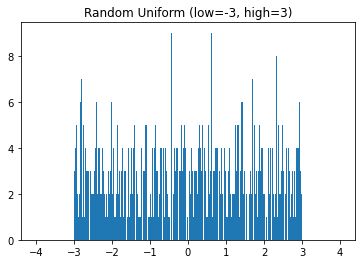

In [3]:
import helpers
helpers.hist_dist('Random Uniform (low=-3, high=3)', np.random.uniform(-3, 3, [1000]))

The histogram used 500 buckets for the 1000 values.  Since the chance for any single bucket is the same, there should be around 2 values for each bucket. That's exactly what we see with the histogram.  Some buckets have more and some have less, but they trend around 2. By picking the initial weights of a model from a distribution like this, we are incorporating some randomness that should help our model train. We can still set some constraints on which values our weights take. 

Now that you understand the uniform function, let's use PyTorch's `nn.init` to apply it to a model's initial weights.

### Uniform Initialization, Baseline


Let's see how well the neural network trains using a uniform weight initialization, where `low=0.0` and `high=1.0`. Below, I'll show you another way (besides in the Net class code) to initialize the weights of a network. To define weights outside of the model definition, you can:
>1. Define a function that assigns weights by the type of network layer, *then* 
2. Apply those weights to an initialized model using `model.apply(fn)`, which applies a function to each model layer.

This time, we'll use `weight.data.uniform_` to initialize the weights of our model, directly.

In [4]:
# takes in a module and applies the specified weight initialization
def weights_init_uniform(m):
    classname = m.__class__.__name__
    # for every Linear layer in a model..
    if classname.find('Linear') != -1:
        # apply a uniform distribution to the weights and a bias=0
        m.weight.data.uniform_(0.0, 1.0)
        m.bias.data.fill_(0)

In [7]:
# create a new model with these weights
model_uniform = Net()
model_uniform.apply(weights_init_uniform)

Net(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

We are going to call `apply(weights_init_uniform)` on it uniform on this model. Apply will recursively call our initialization function and apply uniform weights to every linear layer.

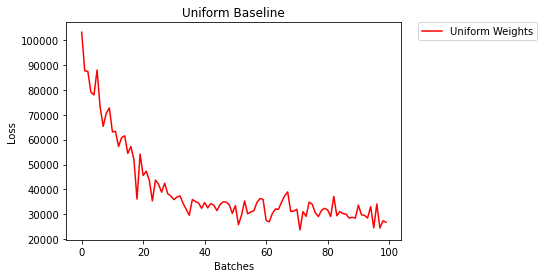

After 2 Epochs:
Validation Accuracy
   35.567% -- Uniform Weights
Training Loss
    5.321  -- Uniform Weights


In [8]:
# evaluate behavior 
helpers.compare_init_weights([(model_uniform, 'Uniform Weights')], 
                             'Uniform Baseline', 
                             train_loader,
                             valid_loader)

---
The loss graph is showing the neural network is learning, which it didn't with all zeros or all ones. We're headed in the right direction!

Now, earlier we did mention that the value of one is actually a bot too high of a good starting weight value. So, choosing weights from a uniform range of values between 0 and 1 is actually not the best range to choose from. We know that for fully-connected layers, each node will see every input value, multiply it by a model weight and then add the weighted values together.  In the case of Fashion MNIST, each hidden node in the first layer s seeing 784 input values. The next layer is seeing 256 input values then 128 as input. Because the model weights act as multiplier for all the inputs, it makes sense that the weights should be somehow related to the number of inputs that each node is going to see. In fact, the relationship is an inverse one. The more inputs a certain model sees, the smaller its weight should be. 

Let's see what eact range we should try. 

## General rule for setting weights
The general rule for setting the weights in a neural network is to set them to be close to zero without being too small. More specifically, we should start with weights and the range of negative y `(-y)`to `y`, where `y`equals `1` over square root `n` and `n`is the number of inputs to a given neuron.

This rule is basically saying two things: the weights should be centered around zero, and the range should be quite small and inversely related to the number of input nodes for a given layer. 

>Good practice is to start your weights in the range of $[-y, y]$ where $y=1/\sqrt{n}$  
($n$ is the number of inputs to a given neuron).

Let's see if this holds true; let's create a baseline to compare with and center our uniform range over zero by shifting it over by 0.5.  This will give us the range [-0.5, 0.5).

In [9]:
# takes in a module and applies the specified weight initialization
def weights_init_uniform_center(m):
    classname = m.__class__.__name__
    # for every Linear layer in a model..
    if classname.find('Linear') != -1:
        # apply a centered, uniform distribution to the weights
        m.weight.data.uniform_(-0.5, 0.5)
        m.bias.data.fill_(0)

# create a new model with these weights
model_centered = Net()
model_centered.apply(weights_init_uniform_center)

Net(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

Then let's create a distribution and model that uses the **general rule** for weight initialization; using the range $[-y, y]$, where $y=1/\sqrt{n}$ .

And finally, we'll compare the two models.

In [10]:
# takes in a module and applies the specified weight initialization
def weights_init_uniform_rule(m):
    classname = m.__class__.__name__
    # for every Linear layer in a model..
    if classname.find('Linear') != -1:
        # get the number of the inputs
        n = m.in_features
        y = 1.0/np.sqrt(n)
        m.weight.data.uniform_(-y, y)
        m.bias.data.fill_(0)

# create a new model with these weights
model_rule = Net()
model_rule.apply(weights_init_uniform_rule)

Net(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

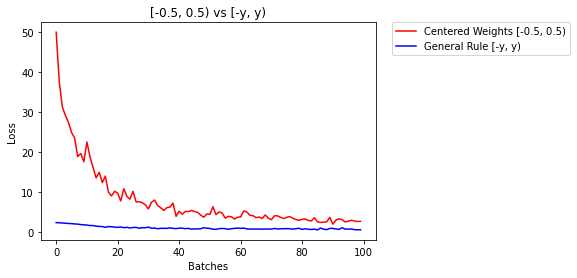

After 2 Epochs:
Validation Accuracy
   75.200% -- Centered Weights [-0.5, 0.5)
   84.058% -- General Rule [-y, y)
Training Loss
    0.956  -- Centered Weights [-0.5, 0.5)
    0.698  -- General Rule [-y, y)


In [11]:
# compare these two models
model_list = [(model_centered, 'Centered Weights [-0.5, 0.5)'), 
              (model_rule, 'General Rule [-y, y)')]

# evaluate behavior 
helpers.compare_init_weights(model_list, 
                             '[-0.5, 0.5) vs [-y, y)', 
                             train_loader,
                             valid_loader)

So first of, we can see on the y-axis that our lost values are orders of magnitude smaller than what we have seen previously. This behavior is really promising. Not only is the lost decreasing for both of these models, but it seems to do so very quicky for a uniform weights that follow the general rule.  After only 2 epochs, we get a fairly high validation accuracy. Almost 86% for using the general rule. 

This should start to give us some intuition for why starting out with the right initial weights can really help our training process. Since the uniform distribution has the same chance of picking any value and arrange, what if we used a distribution that had a higher chance of picking numbers closer to zero? This is the normal distribution which we will look at next. 

This behavior is really promising! Not only is the loss decreasing, but it seems to do so very quickly for our uniform weights that follow the general rule; after only two epochs we get a fairly high validation accuracy and this should give you some intuition for why starting out with the right initial weights can really help your training process!

---

Since the uniform distribution has the same chance to pick *any value* in a range, what if we used a distribution that had a higher chance of picking numbers closer to 0?  Let's look at the normal distribution.